In [1]:
import os, sys, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier as RF
import seaborn as sns
import datetime as dt
import xgboost as xgb

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
ds_train = pd.read_csv('data/ccf_offline_stage1_train.csv')
ds_test = pd.read_csv('data/test_offline.csv')
dfon = pd.read_csv('data/ccf_online_stage1_train.csv')

ds_test = ds_test[~ds_test.Coupon_id.isna()]
ds_test.reset_index(drop=True, inplace=True)

In [3]:
ds_test.shape

(306313, 6)

In [4]:
# 1. 轉換成折扣率 `discount_rate, discount_man, discount_jian, discount_type`
# discount_man 消費多少錢 折多少 discount_jian
# convert Discount_rate and Distance

def getDiscountType(row):
    if pd.isnull(row):
        return np.nan
    elif ':' in row:
        return 1
    else:
        return 0

    
def convertRate(row):
    """Convert discount to rate"""
    if pd.isnull(row):
        return 1.0
    elif ':' in str(row):
        rows = row.split(':')
        return 1.0 - float(rows[1])/float(rows[0])
    else:
        return float(row)

def getDiscountMan(row):
    if ':' in str(row):
        rows = row.split(':')
        return int(rows[0])
    else:
        return 0

def getDiscountJian(row):
    if ':' in str(row):
        rows = row.split(':')
        return int(rows[1])
    else:
        return 0
    
def processData(df):
    # convert discunt_rate
    df['discount_rate'] = df['Discount_rate'].apply(convertRate)
    df['discount_man'] = df['Discount_rate'].apply(getDiscountMan)
    df['discount_jian'] = df['Discount_rate'].apply(getDiscountJian)
    df['discount_type'] = df['Discount_rate'].apply(getDiscountType)
    print(df['discount_rate'].unique())
    # convert distance
    df['distance'] = df['Distance'].fillna(-1).astype(int)
    return df

ds_train = processData(ds_train)
ds_test = processData(ds_test)

[1.         0.86666667 0.95       0.9        0.83333333 0.8
 0.5        0.85       0.75       0.66666667 0.93333333 0.7
 0.6        0.96666667 0.98       0.99       0.975      0.33333333
 0.2        0.4       ]
[0.86666667 0.95       0.83333333 0.8        0.75       0.66666667
 0.9        0.96666667 0.6        0.7        0.5        0.98
 0.85       0.93333333 0.99       0.975      0.33333333]


In [5]:

date_received = ds_train['Date_received'].unique()
date_received = sorted(date_received[pd.notnull(date_received)])

date_buy = ds_train['Date'].unique()
date_buy = sorted(date_buy[pd.notnull(date_buy)])
date_buy = sorted(ds_train[ds_train['Date'].notnull()]['Date'])


#每天 領取 coupon 計算
couponbydate = ds_train[ds_train['Date_received'].notnull()][['Date_received', 'Date']].groupby(['Date_received'], as_index=False)['Date'].agg({'count':np.size})
couponbydate.columns = ['Date_received','count']

#每天消耗 coupon 的数量
buybydate = ds_train[(ds_train['Date'].notnull()) & (ds_train['Date_received'].notnull())][['Date_received', 'Date']].groupby(['Date_received'], as_index=False).count()
buybydate.columns = ['Date_received','count']




C:\Users\sxwdc\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


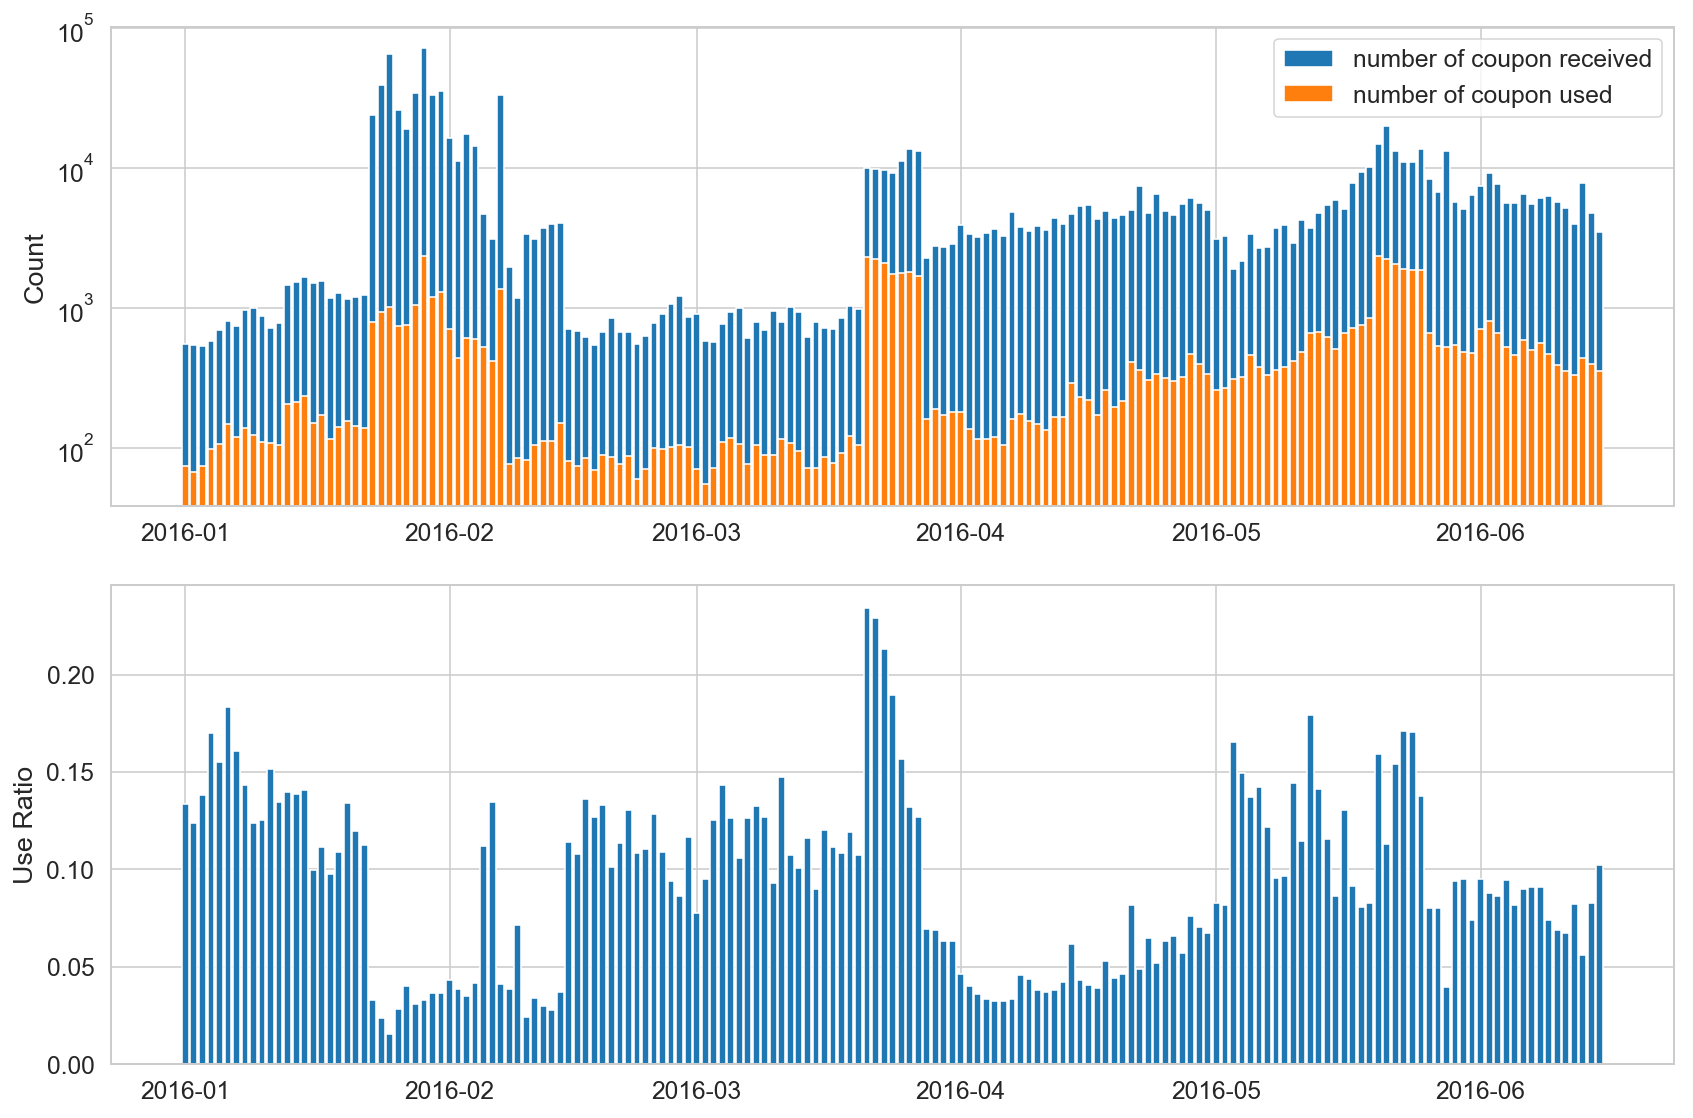

In [6]:
sns.set_style('whitegrid')
sns.set_context("paper", font_scale= 1.4)
plt.figure(figsize = (12,8))
date_received_dt = pd.to_datetime(date_received, format='%Y%m%d')

plt.subplot(211)
plt.bar(date_received_dt, couponbydate['count'], label = 'number of coupon received' )
plt.bar(date_received_dt, buybydate['count'], label = 'number of coupon used')
plt.yscale('log')
plt.ylabel('Count')
plt.legend()

plt.subplot(212)
plt.bar(date_received_dt, buybydate['count']/couponbydate['count'])
plt.ylabel('Use Ratio')
plt.tight_layout()

In [7]:
# 每个user领取coupon的数量(优惠券消费次数)
temp_user_coupon =  ds_train[(ds_train['Date'].notnull()) & (ds_train['Date_received'].notnull())]
user_coupon = temp_user_coupon.groupby(['User_id']).size().reset_index(name='user_coupon')

ds_train = pd.merge(ds_train, user_coupon, how='left', on='User_id')
ds_train.user_coupon.fillna(0, inplace=True)
ds_test = pd.merge(ds_test, user_coupon, how='left', on='User_id')
ds_test.user_coupon.fillna(0, inplace=True)

# 优惠券消费最大间隔
date_coupon= temp_user_coupon.groupby('User_id',as_index= False ).Date.agg({'cmax':max,'cmin':min})
date_coupon[['cmin','cmax']] = date_coupon[['cmin','cmax']].astype('int').astype('str')
date_coupon['cmax'] =date_coupon['cmax'].apply(lambda x : dt.datetime.strptime(x,'%Y%m%d') )
date_coupon['cmin'] =date_coupon['cmin'].apply(lambda x : dt.datetime.strptime(x,'%Y%m%d') )
date_coupon['cdate_interval'] = (date_coupon['cmax'] -date_coupon['cmin']).dt.days


ds_train = pd.merge(ds_train, date_coupon, how='left', on='User_id')
ds_test = pd.merge(ds_test, date_coupon, how='left', on='User_id')
ds_train['cdate_interval'] = ds_train['cdate_interval'].fillna(-1)
ds_test['cdate_interval'] = ds_test['cdate_interval'].fillna(-1)

In [8]:
# 普通消费次数
temp_user_nocoupon =ds_train[(ds_train['Date'].notnull()) & (ds_train['Date_received'].isnull())]
user_nocoupon = temp_user_nocoupon.groupby(['User_id']).size().reset_index(name='user_nocoupon')

ds_train = pd.merge(ds_train, user_nocoupon, how='left', on='User_id')
ds_train.user_nocoupon.fillna(0, inplace=True)
ds_test = pd.merge(ds_test, user_nocoupon, how='left', on='User_id')
ds_test.user_nocoupon.fillna(0, inplace=True)


# 普通消费最大间隔
date1 = temp_user_nocoupon.groupby('User_id',as_index= False ).Date.agg({'max':max,'min':min})
date1[['min','max']] = date1[['min','max']].astype('int').astype('str')
date1['max'] =date1['max'].apply(lambda x : dt.datetime.strptime(x,'%Y%m%d') )
date1['min'] =date1['min'].apply(lambda x : dt.datetime.strptime(x,'%Y%m%d') )
date1['date_interval'] = (date1['max'] -date1['min']).dt.days


ds_train = pd.merge(ds_train, date1, how='left', on='User_id')
ds_test = pd.merge(ds_test, date1, how='left', on='User_id')
ds_train['date_interval'] = ds_train['date_interval'].fillna(-1)
ds_test['date_interval'] = ds_test['date_interval'].fillna(-1)

In [9]:
def getWeekday(row):
    if row == 'nan':
        return np.nan
    else:
        return date(int(row[0:4]), int(row[4:6]), int(row[6:8])).weekday() + 1

ds_train['weekday'] = ds_train['Date_received'].astype('str').apply(getWeekday)
ds_test['weekday'] = ds_test['Date_received'].astype('str').apply(getWeekday)

# weekday_type :  周六和周日为1，其他为0
ds_train['weekday_type'] = ds_train['weekday'].apply(lambda x : 1 if x in [6,7] else 0 )
ds_test['weekday_type'] = ds_test['weekday'].apply(lambda x : 1 if x in [6,7] else 0 )

# change weekday to one-hot encoding 
weekdaycols = ['weekday_' + str(i) for i in range(1,8)]
tmpdf = pd.get_dummies(ds_train['weekday'].replace('nan', np.nan))
tmpdf.columns = weekdaycols
ds_train[weekdaycols] = tmpdf

tmpdf = pd.get_dummies(ds_test['weekday'].replace('nan', np.nan))
tmpdf.columns = weekdaycols
ds_test[weekdaycols] = tmpdf

In [10]:
def label(row):
    if pd.isnull(row['Date_received']):
        return -1
    if pd.notnull(row['Date']):
        td = pd.to_datetime(row['Date'], format='%Y%m%d') -  pd.to_datetime(row['Date_received'], format='%Y%m%d')
        if td <= pd.Timedelta(15, 'D'):
            return 1
    return 0

ds_train['label'] = ds_train.apply(label, axis = 1)


In [11]:
ds_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1754884 entries, 0 to 1754883
Data columns (total 30 columns):
User_id           int64
Merchant_id       int64
Coupon_id         float64
Discount_rate     object
Distance          float64
Date_received     float64
Date              float64
discount_rate     float64
discount_man      int64
discount_jian     int64
discount_type     float64
distance          int32
user_coupon       float64
cmax              datetime64[ns]
cmin              datetime64[ns]
cdate_interval    float64
user_nocoupon     float64
max               datetime64[ns]
min               datetime64[ns]
date_interval     float64
weekday           float64
weekday_type      int64
weekday_1         uint8
weekday_2         uint8
weekday_3         uint8
weekday_4         uint8
weekday_5         uint8
weekday_6         uint8
weekday_7         uint8
label             int64
dtypes: datetime64[ns](4), float64(11), int32(1), int64(6), object(1), uint8(7)
memory usage: 326.3+ MB


In [12]:
# data split
df = ds_train[ds_train['label'] != -1].copy()

df.to_csv('output/df.csv', index=False)

train = df[(df['Date_received'] < 20160516)].copy()
valid = df[(df['Date_received'] >= 20160516) & (df['Date_received'] <= 20160615)].copy()


In [13]:
# feature
df = pd.read_csv('output/df.csv')

print(df.columns)
original_feature = ['discount_rate', 'discount_man',
       'discount_jian', 'discount_type', 'distance', 'user_coupon', 'weekday',
       'weekday_type','user_nocoupon', 'date_interval'] + weekdaycols


Index(['User_id', 'Merchant_id', 'Coupon_id', 'Discount_rate', 'Distance',
       'Date_received', 'Date', 'discount_rate', 'discount_man',
       'discount_jian', 'discount_type', 'distance', 'user_coupon', 'cmax',
       'cmin', 'cdate_interval', 'user_nocoupon', 'max', 'min',
       'date_interval', 'weekday', 'weekday_type', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7',
       'label'],
      dtype='object')


In [14]:
print("----train-----")
SGD = SGDClassifier(#lambda:
    loss='log',
    penalty='elasticnet',
    fit_intercept=True,
    max_iter=100,
    shuffle=True,
    alpha = 0.01,
    l1_ratio = 0.01,
    n_jobs=1,
    class_weight=None
)
SGD.fit(train[original_feature], train['label'])

----train-----


C:\Users\sxwdc\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


SGDClassifier(alpha=0.01, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.01, learning_rate='optimal', loss='log', max_iter=100,
       n_iter=None, n_iter_no_change=5, n_jobs=1, penalty='elasticnet',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [15]:
print(df.columns)
original_feature = ['discount_rate', 'discount_man',
       'discount_jian', 'discount_type', 'distance', 'user_coupon', 'weekday',
       'weekday_type','user_nocoupon', 'date_interval'] + weekdaycols

Index(['User_id', 'Merchant_id', 'Coupon_id', 'Discount_rate', 'Distance',
       'Date_received', 'Date', 'discount_rate', 'discount_man',
       'discount_jian', 'discount_type', 'distance', 'user_coupon', 'cmax',
       'cmin', 'cdate_interval', 'user_nocoupon', 'max', 'min',
       'date_interval', 'weekday', 'weekday_type', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7',
       'label'],
      dtype='object')


In [16]:
# #### 预测以及结果评价

SGD_pre_train=SGD.predict_proba(train[original_feature])
SGD_auc_train = roc_auc_score(train['label'],SGD_pre_train[:,1])
SGD_pre_test=SGD.predict_proba(valid[original_feature])
SGD_auc_valid = roc_auc_score(valid['label'],SGD_pre_test[:,1])


print('SGD_auc_train: ', SGD_auc_train)
print('SGD_auc_valid: ', SGD_auc_valid)


SGD_auc_train:  0.9121854157489311
SGD_auc_valid:  0.8650026088249091


In [17]:
print("---save model---")
with open('myspace/o2o/SGD.pkl', 'wb') as f:
    pickle.dump(SGD, f)


---save model---


In [18]:
SGD.fit(df[original_feature], df['label'])

SGD_final_train=SGD.predict_proba(df[original_feature])
SGD_final_auc_train = roc_auc_score(df['label'],SGD_final_train[:,1])
print('SGD_final_auc_train: ', SGD_final_auc_train)

C:\Users\sxwdc\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


SGD_final_auc_train:  0.9056765565757892


In [19]:
ds_test.replace(np.nan, 0, inplace=True)

In [20]:
# test prediction for submission
y_test_pred = SGD.predict_proba(ds_test[original_feature])
ds_test1 = ds_test[['User_id','Coupon_id','Date_received']].copy()
ds_test1['label'] = y_test_pred[:,1]
ds_test1.to_csv('myspace/o2o/SGDsubmit.csv', index=False, header=False)
ds_test1.head()



,User_id,Coupon_id,Date_received,label
0,1439408,11002.0,20160528.0,0.033248
1,1439408,8591.0,20160613.0,0.163135
2,1439408,8591.0,20160516.0,0.163135
3,2029232,1532.0,20160530.0,0.069057
4,2029232,12737.0,20160519.0,0.072646


** Random Forest

In [21]:
from sklearn.ensemble import RandomForestClassifier # as RF                  
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve,auc                      
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

param_test = { 'max_depth':range(3,5,1)
               ,'n_estimators':range(150,200,30)}

In [22]:
gsearch = GridSearchCV(estimator = RandomForestClassifier(criterion='gini'),
                      param_grid = param_test, cv = KFold(2) ,scoring = 'roc_auc')
gsearch.fit(train[original_feature], train['label'])

rf_model = gsearch.best_estimator_

In [23]:
rf_pre_train = rf_model.predict_proba(train[original_feature])
rf_auc_train = roc_auc_score(train['label'],rf_pre_train[:,1])
rf_pre_test = rf_model.predict_proba(valid[original_feature])
rf_auc_valid = roc_auc_score(valid['label'],rf_pre_test[:,1])
print('rf_auc_train: ', rf_auc_train)
print('rf_auc_valid: ', rf_auc_valid)
           
    
print("---save model---")
with open('myspace/o2o/RF.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

    


rf_auc_train:  0.9695889643612977
rf_auc_valid:  0.9394275955754574
---save model---


In [24]:
# test prediction for submission
y_test_pred = rf_model.predict_proba(ds_test[original_feature])
ds_test1 = ds_test[['User_id','Coupon_id','Date_received']].copy()
ds_test1['label'] = y_test_pred[:,1]
ds_test1.to_csv('myspace/o2o/RFsubmit.csv', index=False, header=False)
ds_test1.head()

,User_id,Coupon_id,Date_received,label
0,1439408,11002.0,20160528.0,0.134632
1,1439408,8591.0,20160613.0,0.290254
2,1439408,8591.0,20160516.0,0.290254
3,2029232,1532.0,20160530.0,0.038723
4,2029232,12737.0,20160519.0,0.041609


***XGBoost

In [25]:
# 融合模型要用到这种写法的xgboost
xgb_params = { 'n_estimators':[100,150], 'max_depth':[2,3] }

xgb_grid = GridSearchCV(xgb.XGBClassifier(),xgb_params,scoring = 'roc_auc',cv = 2)
xgb_grid.fit(train[original_feature],train['label'])
print('xgb最佳参数',xgb_grid.best_params_)
print('-' * 80)

n_estimators = xgb_grid.best_params_['n_estimators']
max_depth = xgb_grid.best_params_['max_depth']

# 最优参数xgb
xgb_model = xgb.XGBClassifier(booster = 'gbtree',
                              objective = 'rank:pairwise',
                              eval_metric = 'auc',
                              learning_rate = 0.1,
                              gamma=0.1, 
                              n_estimators = n_estimators, 
                              max_depth = max_depth,
                              min_child_weight=1.1,
                              subsample= 0.7,
                              colsample_bytree= 0.7,
                              colsample_bylevel= 0.7,
                              eta= 0.01,
                              tree_method= 'exact',
                              nthread= 12,
                              seed = 123,n_jobs=1)

xgb_model.fit(train[original_feature],train['label'])

print("---save model---")
with open('myspace/o2o/xgb_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)

xgb最佳参数 {'max_depth': 3, 'n_estimators': 150}
--------------------------------------------------------------------------------
---save model---


In [26]:

xgb_pre_train = xgb_model.predict_proba(train[original_feature])
xgb_auc_train = roc_auc_score(train['label'],xgb_pre_train[:,1])
xgb_pre_test = xgb_model.predict_proba(valid[original_feature])
xgb_auc_valid = roc_auc_score(valid['label'],xgb_pre_test[:,1])
print('xgb_auc_train: ', xgb_auc_train)
print('xgb_auc_valid: ', xgb_auc_valid)
           

xgb_auc_train:  0.9733998265188487
xgb_auc_valid:  0.9443904602851716


In [27]:
y_test_pred = xgb_model.predict_proba(ds_test[original_feature])

ds_test1 = ds_test[['User_id','Coupon_id','Date_received']].copy()
ds_test1['label'] = y_test_pred[:,1]
ds_test1.label = MinMaxScaler(copy=True, feature_range=(0, 1)).fit_transform(
        ds_test1.label.values.reshape(-1, 1))

ds_test1.to_csv('myspace/o2o/xgbsubmit.csv', index=False, header=False)
ds_test1.head()
    

,User_id,Coupon_id,Date_received,label
0,1439408,11002.0,20160528.0,0.663240
1,1439408,8591.0,20160613.0,0.773626
2,1439408,8591.0,20160516.0,0.773626
3,2029232,1532.0,20160530.0,0.177840
4,2029232,12737.0,20160519.0,0.179600


In [28]:
with open('myspace/o2o/SGD.pkl', 'rb') as f:
    SGD = pickle.load(f)
with open('myspace/o2o/RF.pkl', 'rb') as f:
    RF = pickle.load(f) 
with open('myspace/o2o/xgb_model.pkl', 'rb') as f:
    xgb_model = pickle.load(f)

Mode mixing

In [29]:


def get_stacking_prob(clf, x_train, y_train, x_test, n_folds=2):
    train_num, test_num = x_train.shape[0], x_test.shape[0]
    second_level_train_set = np.zeros((train_num,))
    second_level_test_set = np.zeros((test_num,))
    test_nfolds_sets = np.zeros((test_num, n_folds))
    kf = KFold(n_splits=n_folds)

    for i,(train_index, test_index) in enumerate(kf.split(x_train)):
        x_tra, y_tra = x_train[train_index], y_train[train_index]
        x_tst, y_tst =  x_train[test_index], y_train[test_index]
        clf.fit(x_tra, y_tra)
        second_level_train_set[test_index] = clf.predict_proba(x_tst)[:,1]
        test_nfolds_sets[:,i] = clf.predict_proba(x_test)[:,1]

    second_level_test_set[:] = test_nfolds_sets.mean(axis=1)
    return second_level_train_set, second_level_test_set


In [30]:
x_train_arr = np.array(train[original_feature])
y_train_arr = np.array(train['label'])
x_valid_arr = np.array(valid[original_feature])

train_sets = []
valid_sets = []
for clf in [SGD,RF,xgb_model]:
    train_set, valid_set = get_stacking_prob(clf, x_train_arr, y_train_arr, x_valid_arr)
    train_sets.append(train_set)
    valid_sets.append(valid_set)
    print(clf)

meta_train = np.concatenate([result_set.reshape(-1,1) for result_set in train_sets], axis = 1)  #np.concatenate,axis=1列连接
meta_valid = np.concatenate([y_test_set.reshape(-1,1) for y_test_set in valid_sets], axis = 1)
meta_model = LogisticRegression(random_state = 1)
meta_model.fit(meta_train, train['label'])

prediction = meta_model.predict_proba(meta_valid)
stacking_auc_valid = roc_auc_score(valid['label'],prediction[:,1])
print('\n')
print('stacking_auc_valid: ', stacking_auc_valid)



C:\Users\sxwdc\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\sxwdc\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


SGDClassifier(alpha=0.01, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.01, learning_rate='optimal', loss='log', max_iter=100,
       n_iter=None, n_iter_no_change=5, n_jobs=1, penalty='elasticnet',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.7,
       colsample_bynode=1, colsample_bytree=0.7, eta=0.01,
       eval_metric='auc', gamma=0.1, learning_r

C:\Users\sxwdc\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)




stacking_auc_valid:  0.9447576150456164


In [31]:
ds_test.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,discount_rate,discount_man,discount_jian,discount_type,...,date_interval,weekday,weekday_type,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7
0,1439408,4663,11002.0,150:20:00,1.0,20160528.0,0.866667,150,20,1,...,89.0,6,1,0,0,0,0,0,1,0
1,1439408,2632,8591.0,20:01,0.0,20160613.0,0.950000,20,1,1,...,89.0,1,0,1,0,0,0,0,0,0
2,1439408,2632,8591.0,20:01,0.0,20160516.0,0.950000,20,1,1,...,89.0,1,0,1,0,0,0,0,0,0
3,2029232,450,1532.0,30:05:00,0.0,20160530.0,0.833333,30,5,1,...,38.0,1,0,1,0,0,0,0,0,0
4,2029232,6459,12737.0,20:01,0.0,20160519.0,0.950000,20,1,1,...,38.0,4,0,0,0,0,1,0,0,0


In [32]:
x_test_arr = np.array(ds_test[original_feature])
y_test_pred = np.column_stack([clf.predict_proba(x_test_arr)[:,1]  for clf in [SGD,RF,xgb_model]])
prediction = meta_model.predict_proba(y_test_pred)


ds_test1 = ds_test[['User_id','Coupon_id','Date_received']].copy()
ds_test1['label'] = prediction[:,1]

ds_test1.loc[:, "User_id"] = ds_test1["User_id"].apply(lambda x:str(int(x)))
ds_test1.loc[:, "Coupon_id"] = ds_test1["Coupon_id"].apply(lambda x:str(int(x)))
ds_test1.loc[:, "Date_received"] = ds_test1["Date_received"].apply(lambda x:str(int(x)))
ds_test1["uid"] = ds_test1[["User_id", "Coupon_id", "Date_received"]].apply(lambda x: '_'.join(x.values), axis=1)
ds_test1.reset_index(drop=True, inplace=True)


In [33]:
out = ds_test1.groupby("uid", as_index=False).mean()
out.columns = ["uid", "label"]
out.columns = [["uid", "label"]]
csv_path ='myspace/o2o/submission.csv'
out.to_csv(csv_path, header=["uid", "label"], index=False)

In [34]:
out.shape

(304096, 2)